In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
train_c = pd.read_csv("data/claims_train.csv")
test_c = pd.read_csv("data/claims_train.csv")


In [65]:
# Antag at train_c (og evt. test_c) allerede er loaded.
train_c = train_c[train_c["Exposure"] <= 1].copy()

ID_COL = "IDpol"
CATEGORICAL_COLS = ["Area","VehBrand","VehGas","Region"]
NUM_COLS = ["VehPower","VehAge","DrivAge","BonusMalus","Density"]

# Rate og vægt
train_c["rate"] = train_c["ClaimNb"] / train_c["Exposure"]
portfolio_rate = train_c["ClaimNb"].sum() / train_c["Exposure"].sum()
print(f"Porteføljerate (train): {portfolio_rate:.4f}, rækker: {len(train_c)}")


Porteføljerate (train): 0.1007, rækker: 541416


In [66]:
zero_share = (train_c["ClaimNb"]==0).mean()
counts = (train_c["ClaimNb"].value_counts()
          .sort_index()
          .to_frame("antal"))
summary = pd.Series({
    "Porteføljerate": portfolio_rate,
    "Andel 0 skader": zero_share
})
display(summary.to_frame("værdi"))
display(counts.head(10))

,værdi
Porteføljerate,0.100690
Andel 0 skader,0.949817


,antal
ClaimNb,
0,514246
1,25679
2,1414
3,67
4,4
5,2
6,1
9,1
11,2


In [67]:
# Kardinalitet pr. kategori og andel "små" levels
card = {c: train_c[c].nunique() for c in CATEGORICAL_COLS}
rare_tables = {}
for c in CATEGORICAL_COLS:
    vc = train_c[c].value_counts()
    rare = vc[vc < 1000]   # tærskel kan justeres efter porteføljestørrelse
    rare_tables[c] = pd.DataFrame({"count": vc, "is_rare": vc.index.isin(rare.index)})
    print(f"{c}: {card[c]} levels, hvoraf {len(rare)} er 'rare' (<1000)")
display({k: v[v["is_rare"]].head(10) for k,v in rare_tables.items()})


Area: 6 levels, hvoraf 0 er 'rare' (<1000)
VehBrand: 11 levels, hvoraf 0 er 'rare' (<1000)
VehGas: 2 levels, hvoraf 0 er 'rare' (<1000)
Region: 22 levels, hvoraf 0 er 'rare' (<1000)


{'Area': Empty DataFrame
 Columns: [count, is_rare]
 Index: [],
 'VehBrand': Empty DataFrame
 Columns: [count, is_rare]
 Index: [],
 'VehGas': Empty DataFrame
 Columns: [count, is_rare]
 Index: [],
 'Region': Empty DataFrame
 Columns: [count, is_rare]
 Index: []}

In [69]:
q = train_c[NUM_COLS].quantile([0.01,0.05,0.5,0.75,0.95,0.99]).T
q.columns = ["p01","p05","p50","p75", "p95","p99"]
q["min"] = train_c[NUM_COLS].min()
q["max"] = train_c[NUM_COLS].max()
display(q[["min","p01","p05","p50","p75","p95","p99","max"]])


,min,p01,p05,p50,p75,p95,p99,max
VehPower,4,4.0,4.0,6.0,7.0,11.0,13.0,15
VehAge,0,0.0,0.0,6.0,11.0,17.0,21.0,100
DrivAge,18,20.0,25.0,44.0,55.0,72.0,80.0,100
BonusMalus,50,50.0,50.0,50.0,64.0,95.0,106.0,230
Density,1,10.0,20.0,393.0,1662.0,7313.0,27000.0,27000


In [70]:
def rate_by(col):
    tab = (train_c
           .groupby(col)
           .apply(lambda g: pd.Series({
               "Exposure_sum": g["Exposure"].sum(),
               "Claim_sum":    g["ClaimNb"].sum(),
               "rate":         g["ClaimNb"].sum()/g["Exposure"].sum()
           }))
           .sort_values("rate", ascending=False))
    return tab

for col in CATEGORICAL_COLS:
    print(f"\n=== {col} (top 12 efter rate) ===")
    display(rate_by(col).head(12))



=== Area (top 12 efter rate) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\1951498038.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Exposure_sum,Claim_sum,rate
Area,,,
F,6520.617892,931.0,0.142778
E,50841.999316,6183.0,0.121612
D,61411.197762,6686.0,0.108873
C,83145.920532,7886.0,0.094845
B,34369.513561,3050.0,0.088741
A,49449.991542,4035.0,0.081598



=== VehBrand (top 12 efter rate) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\1951498038.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Exposure_sum,Claim_sum,rate
VehBrand,,,
B12,51785.121067,7050.0,0.136139
B11,5465.010589,583.0,0.106679
B5,16010.108155,1626.0,0.101561
B3,22725.482517,2229.0,0.098084
B13,5349.203653,520.0,0.097211
B4,11000.470832,1056.0,0.095996
B6,12511.278867,1165.0,0.093116
B10,7589.189007,690.0,0.090919
B1,75931.719202,6898.0,0.090845



=== VehGas (top 12 efter rate) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\1951498038.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Exposure_sum,Claim_sum,rate
VehGas,,,
Regular,149745.966279,15526.0,0.103682
Diesel,135993.274326,13245.0,0.097395



=== Region (top 12 efter rate) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\1951498038.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Exposure_sum,Claim_sum,rate
Region,,,
R21,945.913198,134.0,0.141662
R94,1412.413397,188.0,0.133106
R11,24160.197652,3190.0,0.132035
R22,2842.750752,348.0,0.122417
R42,953.997482,112.0,0.117401
R82,36137.037569,4035.0,0.111658
R74,1914.890752,210.0,0.109667
R93,28437.288090,3104.0,0.109152
R91,11631.907575,1234.0,0.106088


In [71]:
def binned_rate(col, bins=12):
    cut = pd.qcut(train_c[col], q=bins, duplicates="drop")
    tab = (train_c
           .groupby(cut)
           .apply(lambda g: pd.Series({
               "Exposure_sum": g["Exposure"].sum(),
               "rate": g["ClaimNb"].sum()/g["Exposure"].sum()
           })))
    tab.index.name = f"{col} bin"
    return tab

for col in NUM_COLS:
    print(f"\n=== {col} (q-bins) ===")
    display(binned_rate(col, bins=12))



=== VehPower (q-bins) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\340698375.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cut)


,Exposure_sum,rate
VehPower bin,,
"(3.999, 5.0]",102418.003743,0.101359
"(5.0, 6.0]",65810.572274,0.101534
"(6.0, 7.0]",62063.706155,0.098334
"(7.0, 8.0]",17994.213245,0.082527
"(8.0, 10.0]",24527.754927,0.115013
"(10.0, 15.0]",12924.990261,0.100503



=== VehAge (q-bins) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\340698375.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cut)


,Exposure_sum,rate
VehAge bin,,
"(-0.001, 1.0]",39352.560398,0.164716
"(1.0, 2.0]",23695.986854,0.093898
"(2.0, 3.0]",20822.517489,0.088750
"(3.0, 5.0]",36639.147609,0.095090
"(5.0, 6.0]",16509.997445,0.104058
"(6.0, 8.0]",30660.679692,0.099900
"(8.0, 9.0]",15011.743437,0.098323
"(9.0, 11.0]",30832.313784,0.097333
"(11.0, 13.0]",26556.586753,0.085064



=== DrivAge (q-bins) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\340698375.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cut)


,Exposure_sum,rate
DrivAge bin,,
"(17.999, 27.0]",20633.327519,0.153441
"(27.0, 31.0]",21535.939251,0.096118
"(31.0, 34.0]",19287.243642,0.089593
"(34.0, 38.0]",27652.737288,0.088743
"(38.0, 41.0]",20921.488569,0.096408
"(41.0, 44.0]",20982.348560,0.098178
"(44.0, 48.0]",27844.475717,0.106700
"(48.0, 51.0]",22012.176893,0.108077
"(51.0, 55.0]",28287.488071,0.098630



=== BonusMalus (q-bins) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\340698375.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cut)


,Exposure_sum,rate
BonusMalus bin,,
"(49.999, 51.0]",186214.581617,0.079806
"(51.0, 57.0]",21372.716432,0.091799
"(57.0, 64.0]",21672.589610,0.140177
"(64.0, 76.0]",24120.679945,0.119565
"(76.0, 90.0]",18803.346105,0.139603
"(90.0, 230.0]",13555.326895,0.250898



=== Density (q-bins) ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\340698375.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cut)


,Exposure_sum,rate
Density bin,,
"(0.999, 29.0]",28192.497846,0.079064
"(29.0, 54.0]",25779.893815,0.085765
"(54.0, 91.0]",25387.230018,0.087642
"(91.0, 149.0]",25607.537254,0.092824
"(149.0, 233.0]",23930.578542,0.093228
"(233.0, 393.0]",24210.855321,0.094255
"(393.0, 642.0]",24198.587792,0.101783
"(642.0, 1064.0]",22694.378838,0.114478
"(1064.0, 1662.0]",23274.694460,0.101527


In [73]:
# Eksempel 1: Region x VehGas
tab_rg = (train_c
          .groupby(["Region","VehGas"])
          .apply(lambda g: g["ClaimNb"].sum()/g["Exposure"].sum())
          .unstack().sort_index())
display(tab_rg)

# Eksempel 2: Binnet DrivAge x VehPower
import pandas as pd
A = pd.qcut(train_c["DrivAge"], q=8, duplicates="drop")
B = pd.qcut(train_c["VehPower"], q=6, duplicates="drop")
tab_ab = (train_c
          .groupby([A,B])
          .apply(lambda g: g["ClaimNb"].sum()/g["Exposure"].sum())
          .unstack())
tab_ab.index.name, tab_ab.columns.name = "DrivAge bin", "VehPower bin"
display(tab_ab)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\2310390029.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["ClaimNb"].sum()/g["Exposure"].sum())


VehGas,Diesel,Regular
Region,,
R11,0.118882,0.139938
R21,0.128327,0.161104
R22,0.117193,0.128631
R23,0.094647,0.101866
R24,0.089468,0.088932
R25,0.093195,0.091906
R26,0.083802,0.113712
R31,0.098906,0.109125
R41,0.075530,0.073960


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\2310390029.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([A,B])


VehPower bin,"(3.999, 5.0]","(5.0, 6.0]","(6.0, 7.0]","(7.0, 8.0]","(8.0, 15.0]"
DrivAge bin,,,,,
"(17.999, 29.0]",0.128095,0.135722,0.143599,0.156629,0.156577
"(29.0, 34.0]",0.086753,0.086175,0.089289,0.075450,0.118968
"(34.0, 39.0]",0.097525,0.078102,0.086193,0.067471,0.109624
"(39.0, 44.0]",0.098422,0.101848,0.098671,0.066579,0.103453
"(44.0, 50.0]",0.110226,0.107849,0.105414,0.082895,0.113084
"(50.0, 55.0]",0.100550,0.103525,0.097617,0.088786,0.107337
"(55.0, 63.0]",0.090348,0.091329,0.089840,0.076974,0.100623
"(63.0, 100.0]",0.094451,0.107049,0.088737,0.077322,0.091728


In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

num = train_c[NUM_COLS].copy()
corr = num.corr()
display(corr.style.background_gradient(cmap="coolwarm").format("{:.2f}"))

Xnum = num.assign(const=1.0).values
vif = pd.Series(
    [variance_inflation_factor(Xnum, i) for i in range(Xnum.shape[1]-1)],
    index=NUM_COLS, name="VIF"
)
display(vif.to_frame())


,VehPower,VehAge,DrivAge,BonusMalus,Density
VehPower,1.00,-0.01,0.03,-0.08,0.04
VehAge,-0.01,1.00,-0.06,0.08,-0.09
DrivAge,0.03,-0.06,1.00,-0.48,-0.00
BonusMalus,-0.08,0.08,-0.48,1.00,0.08
Density,0.04,-0.09,-0.00,0.08,1.00


,VIF
VehPower,1.008342
VehAge,1.016541
DrivAge,1.301546
BonusMalus,1.322031
Density,1.019787


A variance inflation factor (VIF) tells you whether one of your variables is too similar to any others in your model. Researchers and statisticians use VIF to identify potential problems in models, to interpret complex datasets, to validate their findings, and to avoid misleading conclusions. A high VIF can make your model confusing and difficult to interpret, while a low VIF is more stable.

VIF equal to 1 = variables are not correlated
VIF between 1 and 5 = variables are moderately correlated 
VIF greater than 5 = variables are highly correlated

In [77]:
# Simpel overdispersion: var/mean på counts pr. "celle" (aggreger let)
cell = train_c.groupby(["Area","Region","VehGas"]).agg(
    y=("ClaimNb","sum"), e=("Exposure","sum")
).reset_index()
cell["mu"] = cell["e"] * (train_c["ClaimNb"].sum() / train_c["Exposure"].sum())
overdisp_ratio = cell["y"].var() / cell["y"].mean()
print(f"Overdispersion (var/mean) ~ {overdisp_ratio:.2f} (>>1 tyder på NegBin)")

# Alternativ: Pearson-dispersion under simpel Poisson GLM (kun hvis statsmodels er ok at bruge)
import statsmodels.api as sm, statsmodels.formula.api as smf
m = smf.glm("ClaimNb ~ 1", data=train_c, family=sm.families.Poisson(),
            offset=np.log(train_c["Exposure"])).fit()
pearson_chi2 = ((train_c["ClaimNb"] - m.mu)**2 / np.maximum(m.mu, 1e-6)).sum()
dispersion = pearson_chi2 / (len(train_c) - m.df_model - 1)
print(f"Pearson-dispersion ~ {dispersion:.2f}")


Overdispersion (var/mean) ~ 347.83 (>>1 tyder på NegBin)
Pearson-dispersion ~ 2.86


Forklaret varians PC1/PC2 (%): [30.25 21.99]


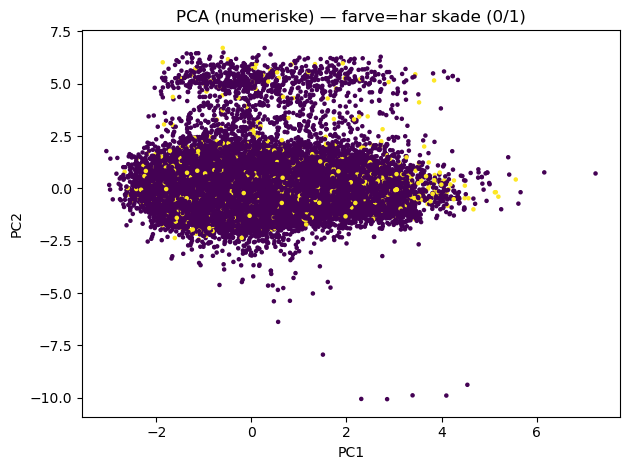

,k,silhouette,calinski,dbi
0,3,0.452657,345437.53125,0.848315
1,4,0.356507,386246.09375,0.869040
4,7,0.320039,372495.65625,0.891599
2,5,0.319062,374924.68750,0.880866
5,8,0.317570,363672.12500,0.875727
3,6,0.298431,363531.09375,0.951035


Valgt k: 3  (sil=0.453)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2884\679720730.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,cluster,n,Exposure_sum,obs_freq
2,2,32383.0,13789.262099,0.144243
1,1,144494.0,62635.730847,0.134460
0,0,364539.0,209314.247658,0.087715


In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np, matplotlib.pyplot as plt

# PCA på numeriske (hurtigt og stabilt)
num_df = train_c[NUM_COLS].fillna(train_c[NUM_COLS].median())
Xn = StandardScaler().fit_transform(num_df)
pca = PCA(n_components=2, svd_solver="randomized", random_state=0)
X2 = pca.fit_transform(Xn).astype("float32")
print("Forklaret varians PC1/PC2 (%):", (pca.explained_variance_ratio_*100).round(2))

# Visualisering (samplet)
rng = np.random.RandomState(0)
idx = rng.choice(len(X2), size=min(50000, len(X2)), replace=False)
had_claim = (train_c["ClaimNb"]>0).astype(int).values
plt.figure(); plt.scatter(X2[idx,0], X2[idx,1], c=had_claim[idx], s=5)
plt.title("PCA (numeriske) — farve=har skade (0/1)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# KMeans i PCA-plan (hurtig udvælgelse af k)
KS = [3,4,5,6,7,8]; SIL_SAMPLE = 5000
idx_sil = rng.choice(len(X2), size=min(SIL_SAMPLE, len(X2)), replace=False)

res = []
for k in KS:
    km = MiniBatchKMeans(n_clusters=k, batch_size=8192, n_init=10, random_state=0)
    labels = km.fit_predict(X2)
    sil = silhouette_score(X2[idx_sil], labels[idx_sil])
    ch  = calinski_harabasz_score(X2, labels)
    dbi = davies_bouldin_score(X2, labels)
    res.append({"k":k,"silhouette":sil,"calinski":ch,"dbi":dbi,"labels":labels})

res_df = pd.DataFrame([{k:v for k,v in r.items() if k!="labels"} for r in res])
display(res_df.sort_values(["silhouette","calinski","dbi"], ascending=[False,False,True]))

best = max(res, key=lambda r: (r["silhouette"], r["calinski"], -r["dbi"]))
best_k, best_labels = best["k"], best["labels"]
print(f"Valgt k: {best_k}  (sil={best['silhouette']:.3f})")

# Clusterprofil (eksponering-vægtet frekvens)
prof = (pd.DataFrame({"cluster": best_labels, "Exposure": train_c["Exposure"].values,
                      "ClaimNb": train_c["ClaimNb"].values})
        .groupby("cluster")
        .apply(lambda g: pd.Series({
            "n": len(g),
            "Exposure_sum": g["Exposure"].sum(),
            "obs_freq": g["ClaimNb"].sum()/g["Exposure"].sum()
        }))
        .reset_index()
        .sort_values("obs_freq", ascending=False))
display(prof.head(10))


In [82]:
import numpy as np, pandas as pd

def psi(series_train, series_test, bins=10):
    # kvantilbuckets på train, mål fordelingen i test
    q = np.linspace(0,1,bins+1)
    cuts = series_train.quantile(q).unique()  # undgå dupl.
    train_bins = pd.cut(series_train, bins=np.unique(cuts), include_lowest=True)
    test_bins  = pd.cut(series_test,  bins=np.unique(cuts), include_lowest=True)
    pt = train_bins.value_counts(normalize=True, sort=False).clip(1e-9)
    pe = test_bins.value_counts(normalize=True, sort=False).clip(1e-9)
    return float(((pt - pe) * np.log(pt/pe)).sum())

if "test_c" in globals():
    for col in ["VehPower","VehAge","DrivAge","BonusMalus","Density"]:
        v = psi(train_c[col], test_c[col])
        print(f"PSI {col}: {v:.3f} (>=0.2 tyder på drift)")


PSI VehPower: 0.000 (>=0.2 tyder på drift)
PSI VehAge: 0.000 (>=0.2 tyder på drift)
PSI DrivAge: 0.000 (>=0.2 tyder på drift)
PSI BonusMalus: 0.000 (>=0.2 tyder på drift)
PSI Density: 0.000 (>=0.2 tyder på drift)


In [76]:
# Antal distinkte værdier pr. kolonne
train_c.nunique().sort_values(ascending=False)


IDpol         541416
Density         1606
rate             201
BonusMalus       115
Exposure         112
DrivAge           83
VehAge            76
Region            22
VehPower          12
VehBrand          11
ClaimNb            9
Area               6
VehGas             2
dtype: int64

In [60]:
portfolio_rate = train_c["ClaimNb"].sum() / train_c["Exposure"].sum()
zero_share     = (train_c["ClaimNb"]==0).mean()
print(f"Porteføljerate: {portfolio_rate:.4f}")
print(f"Andel med 0 skader: {zero_share:.2%}")


Porteføljerate: 0.1007
Andel med 0 skader: 94.98%


In [61]:
print(f"Exposure > 1: {(train_c["Exposure"] > 1).sum()}" )


train_c = train_c[train_c["Exposure"] <= 1]
print("Exposure above 1 is dropped")

Exposure > 1: 0
Exposure above 1 is dropped


Text(0.5, 0, 'Exposure')

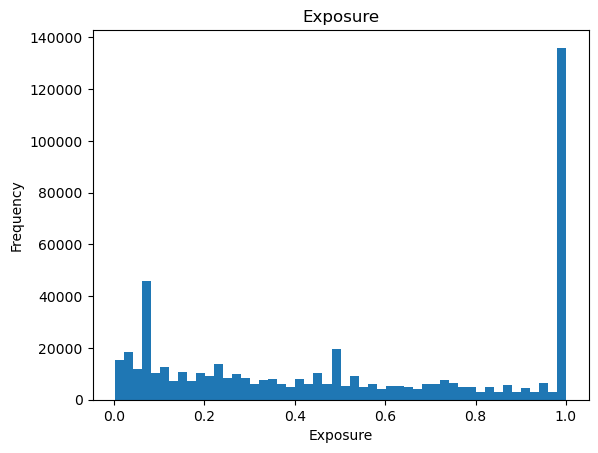

In [62]:
ax = train_c["Exposure"].plot(kind="hist", bins=50, title="Exposure")
ax.set_xlabel("Exposure")


In [63]:
(train_c["ClaimNb"].value_counts()
        .sort_index()
        .to_frame("count"))


,count
ClaimNb,
0,514246
1,25679
2,1414
3,67
4,4
5,2
6,1
9,1
11,2


Text(0.5, 0, 'rate')

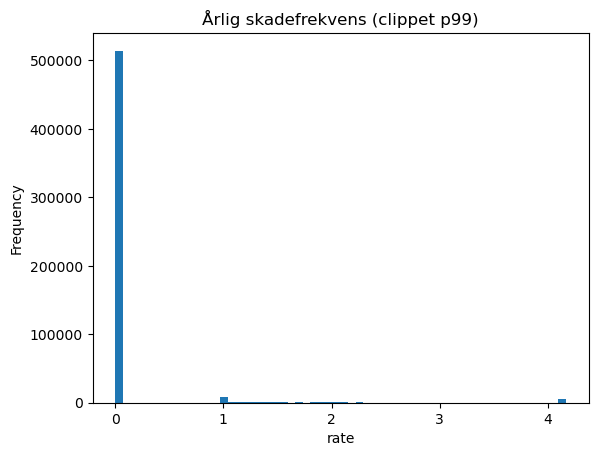

In [64]:
train_c["rate"] = train_c["ClaimNb"] / train_c["Exposure"]
train_c["rate"].describe()

ax = train_c["rate"].clip(upper=train_c["rate"].quantile(0.99)).plot(kind="hist", bins=60,
        title="Årlig skadefrekvens (clippet p99)")
ax.set_xlabel("rate")


In [83]:
print(train_c.shape, test_c.shape)
print("Overlap i IDpol:", len(set(train_c["IDpol"]) & set(test_c["IDpol"])))


(542410, 12) (542410, 12)
Overlap i IDpol: 542410


In [86]:
comp = pd.DataFrame({
    "train": train_c["DrivAge"].value_counts(normalize=True).sort_index(),
    "test":  test_c["DrivAge"].value_counts(normalize=True).sort_index(),
}).fillna(0.0)
comp["abs_diff_pp"] = 100*(comp["test"] - comp["train"])
display(comp.head(20))


,train,test,abs_diff_pp
DrivAge,,,
18,0.001104,0.001104,0.0
19,0.003494,0.003494,0.0
20,0.005450,0.005450,0.0
21,0.006495,0.006495,0.0
22,0.007830,0.007830,0.0
23,0.009227,0.009227,0.0
24,0.010900,0.010900,0.0
25,0.012830,0.012830,0.0
26,0.015121,0.015121,0.0


In [87]:
import numpy as np, pandas as pd

def psi_num(train_s, test_s, bins=10, eps=1e-9):
    # Fastsæt bins på train (lige brede kvantiler)
    qs = np.linspace(0, 1, bins+1)
    cuts = np.unique(train_s.quantile(qs))
    train_b = pd.cut(train_s, bins=cuts, include_lowest=True, duplicates="drop")
    test_b  = pd.cut(test_s,  bins=cuts, include_lowest=True, duplicates="drop")

    pt = train_b.value_counts(normalize=True, sort=False).clip(lower=eps)
    pe = test_b.value_counts(normalize=True, sort=False).clip(lower=eps)
    return float(((pt - pe) * np.log(pt/pe)).sum())

for col in ["VehPower","VehAge","DrivAge","BonusMalus","Density"]:
    print(col, "PSI:", round(psi_num(train_c[col], test_c[col], bins=10), 4))


VehPower PSI: 0.0
VehAge PSI: 0.0
DrivAge PSI: 0.0
BonusMalus PSI: 0.0
Density PSI: 0.0


In [88]:
from scipy.stats import ks_2samp
for col in ["VehPower","VehAge","DrivAge","BonusMalus","Density"]:
    stat, p = ks_2samp(train_c[col].values, test_c[col].values)
    print(f"{col}: KS={stat:.3f}, p={p:.3g}")


VehPower: KS=0.000, p=1
VehAge: KS=0.000, p=1
DrivAge: KS=0.000, p=1
BonusMalus: KS=0.000, p=1
Density: KS=0.000, p=1


In [89]:
def psi_cat(train_s, test_s, eps=1e-9):
    idx = pd.Index(sorted(set(train_s.unique()) | set(test_s.unique())))
    pt = train_s.value_counts(normalize=True).reindex(idx).fillna(0).clip(lower=eps)
    pe = test_s.value_counts(normalize=True).reindex(idx).fillna(0).clip(lower=eps)
    return float(((pt - pe) * np.log(pt/pe)).sum())

for col in ["Area","VehBrand","VehGas","Region"]:
    print(col, "PSI:", round(psi_cat(train_c[col], test_c[col]), 4))


Area PSI: 0.0
VehBrand PSI: 0.0
VehGas PSI: 0.0
Region PSI: 0.0
